unetでセンサデータの補完を行えるように

データ用意

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import torch.backends.cudnn as cudnn
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, TensorDataset
from diffusers import DDPMScheduler, UNet1DModel, UNet2DModel

# For reproducibility
np.random.seed(42)
torch.manual_seed(42) # 乱数生成シード
cudnn.benchmark = True

# Grab a GPU if there is one
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using {} device: {}".format(device, torch.cuda.current_device()))
else:
    device = torch.device("cpu")
    print("Using {}".format(device))

Using cuda device: 0


In [2]:
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True,transform=torchvision.transforms.ToTensor())

In [3]:
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

torch.Size([8, 1, 28, 28])
tensor([1, 2, 8, 5, 2, 6, 9, 9])


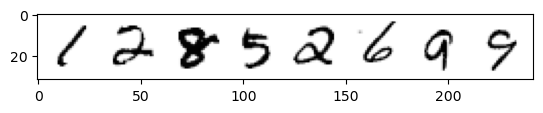

In [4]:
x, y = next(iter(train_dataloader))
print(x.shape)
print(y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

corruputionプロセス  
ここではノイズを追加する。  
ノイズの量をパラメータに入れていくらしい

In [5]:
def corrupt(x, amount):
    noise = torch.rand_like(x)
    amount = amount.view(-1,1,1,1)
    return x*(1-amount) + noise*amount

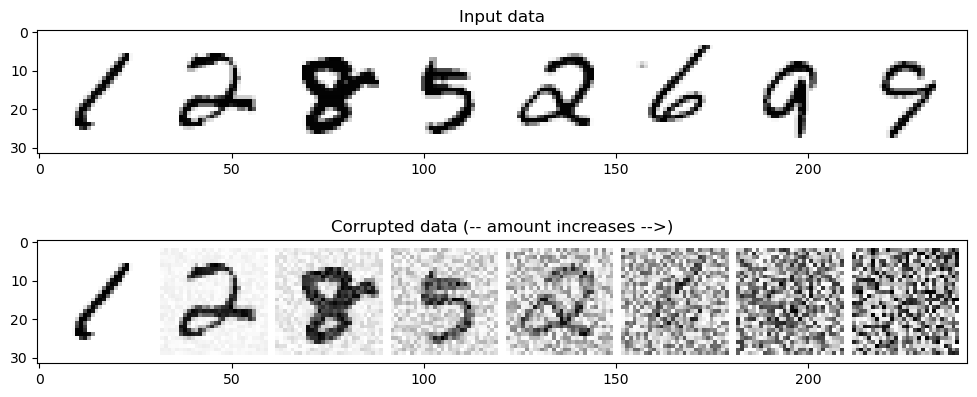

In [6]:
fig, axs = plt.subplots(2,1, figsize=(12,5))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')
# Adding noise
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)
# Plotting the noised version
axs[1].set_title('Corrupted data (-- amount increases -->)')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys')

In [7]:
class BasicUNet(nn.Module):
    """A minimal UNet implementation."""
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
        ])
        self.act = nn.SiLU() # The activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)
    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x)) # Through the layer and the activation function
            if i < 2: # For all but the third (final) down layer:
                h.append(x) # Storing output for skip connection
                x = self.downscale(x) # Downscale ready for the next layer
        for i, l in enumerate(self.up_layers):
            if i > 0: # For all except the first up layer
                x = self.upscale(x) # Upscale
                x += h.pop() # Fetching stored output (skip connection)
            x = self.act(l(x)) # Through the layer and the activation function
        return x


In [11]:
net = BasicUNet()
x = torch.rand(8, 1, 28, 28)
net(x).shape

torch.Size([8, 1, 28, 28])

Finished epoch 0. Average loss for this epoch: 0.026249
Finished epoch 1. Average loss for this epoch: 0.019987
Finished epoch 2. Average loss for this epoch: 0.018590
Finished epoch 3. Average loss for this epoch: 0.017520
Finished epoch 4. Average loss for this epoch: 0.017098
Finished epoch 5. Average loss for this epoch: 0.016770
Finished epoch 6. Average loss for this epoch: 0.016438
Finished epoch 7. Average loss for this epoch: 0.016156
Finished epoch 8. Average loss for this epoch: 0.016120
Finished epoch 9. Average loss for this epoch: 0.015899


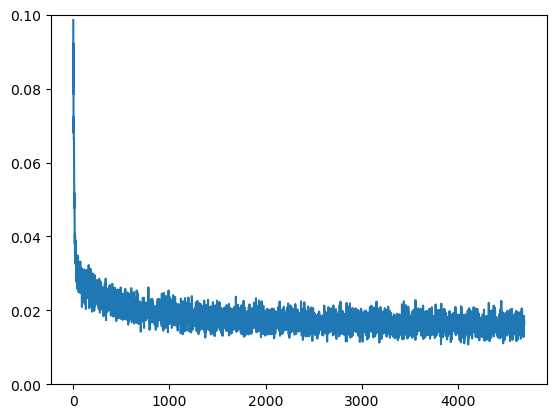

In [12]:

# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# How many runs through the data should we do?
n_epochs = 10
# Create the network
net = BasicUNet()
net.to(device)
# Our loss function
loss_fn = nn.MSELoss()
# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)
# Keeping a record of the losses for later viewing
losses = []
# The training loop
for epoch in range(n_epochs):
    for x, y in train_dataloader:
        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x
        # Get the model prediction
        pred = net(noisy_x)
        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?
        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()
        # Store the loss for later
        losses.append(loss.item())
    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')
# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1);

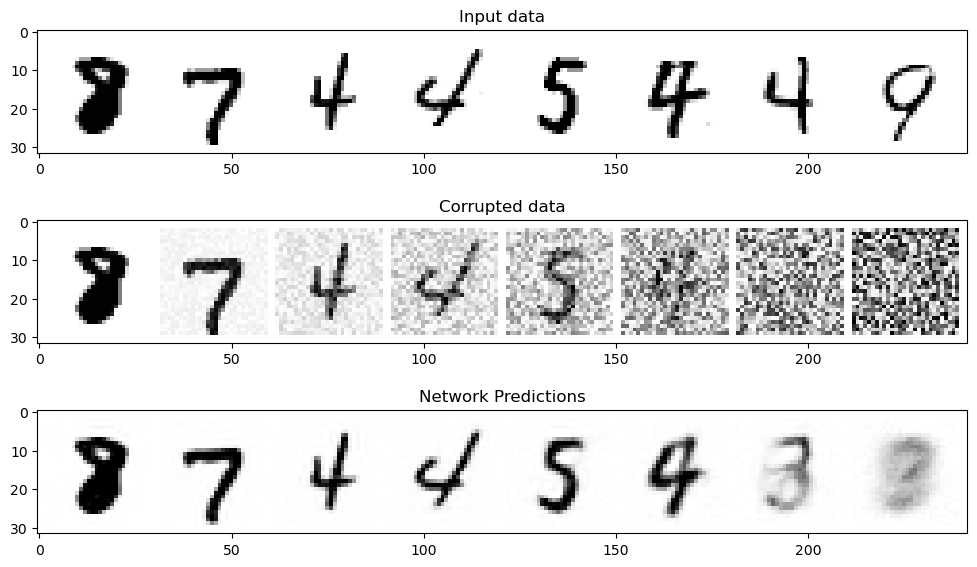

In [13]:

#@markdown Visualizing model predictions on noisy inputs:
# Fetch some data
x, y = next(iter(train_dataloader))
x = x[:8] # Only using the first 8 for easy plotting
# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)
# Get the model predictions
with torch.no_grad():
 preds = net(noised_x.to(device)).detach().cpu()
# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap='Greys')
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap='Greys');